In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
import torch.optim as optim
from torch.utils import data

In [4]:
import nflib
from nflib.flows import SequentialFlow, ActNorm, ActNorm2D, BatchNorm1DFlow, BatchNorm2DFlow
import nflib.coupling_flows as icf
import nflib.res_flow as irf

### Datasets

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# train_dataset = datasets.MNIST(root="./data/", train=True, download=True, transform=train_transform)
# test_dataset = datasets.MNIST(root="./data/", train=False, download=True, transform=test_transform)

train_dataset = datasets.FashionMNIST(root="./data/", train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root="./data/", train=False, download=True, transform=test_transform)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=2)

In [7]:
for xx, yy in train_loader:
    break

In [8]:
xx.shape

torch.Size([50, 1, 28, 28])

### Model

In [9]:
actf = irf.Swish
Norm1D = BatchNorm1DFlow
Norm2D = BatchNorm2DFlow
# Norm1D = ActNorm
# Norm2D = ActNorm2D
flows = [
    Norm2D(1),
    irf.ConvResidualFlow([1, 28, 28], [16], kernels=3, activation=actf),
    irf.InvertiblePooling(2),
    Norm2D(4),
    irf.ConvResidualFlow([4, 14, 14], [64], kernels=3, activation=actf),
    irf.InvertiblePooling(2),
    Norm2D(16),
    irf.ConvResidualFlow([16, 7, 7], [64, 64], kernels=3, activation=actf),
    Norm2D(16),
    irf.Flatten(img_size=[16, 7, 7]),
    Norm1D(16*7*7),
    nn.Linear(784, 2),
    Norm1D(2),
        ]
        

# backbone = SequentialFlow(flows)
backbone = nn.Sequential(*flows)

In [10]:
backbone.to(device)

Sequential(
  (0): BatchNorm2DFlow()
  (1): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Swish()
      (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (2): InvertiblePooling()
  (3): BatchNorm2DFlow()
  (4): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Swish()
      (2): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (5): InvertiblePooling()
  (6): BatchNorm2DFlow()
  (7): ConvResidualFlow(
    (resblock): ModuleList(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Swish()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Swish()
      (4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (8): BatchNorm2DFlow()
  (9): Flatten()
  (10): BatchNorm

In [11]:
backbone(xx.to(device)).shape, 28*28*1

(torch.Size([50, 2]), 784)

In [12]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                irf.remove_spectral_norm_conv(child)
                print("Success : irf conv")
            except Exception as e:
#                     print(e)
                print("Failed : irf conv")

            try:
                irf.remove_spectral_norm(child)
                print("Success : irf lin")
            except Exception as e:
#                     print(e)
                print("Failed : irf lin")

            try:
                nn.utils.remove_spectral_norm(child)
                print("Success : nn")
            except Exception as e:
#                     print(e)
                print("Failed : nn")
    return

In [13]:
# remove_spectral_norm(backbone)

In [14]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))

number of params:  63641


In [15]:
for xx, yy in train_loader:
    tt = backbone(xx.to(device))
    print(xx.shape, tt.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50, 2])


In [16]:
class ConnectedClassifier_Linear(nn.Module):

    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        self.linear = nn.Linear(input_dim, num_sets)

        init_val = torch.randn(num_sets, output_dim)
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None


    def forward(self, x, hard=False):
        x = self.linear(x)*torch.exp(self.inv_temp)
        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x, dim=1)
#             x = torch.softmax(x*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [17]:
class ConnectedClassifier_Distance(nn.Module):

    def __init__(self,input_dim, num_sets, output_dim, inv_temp=0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        self.bias = nn.Parameter(torch.zeros(1, num_sets))
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 5
        self.cls_weight = nn.Parameter(init_val)

        self.cls_confidence = None


    def forward(self, x, hard=False):

        dists = torch.cdist(x, self.centers)
        ### correction to make diagonal of unit square 1 in nD space
        dists = dists/np.sqrt(self.input_dim) + self.bias
        dists = dists*torch.exp(self.inv_temp)
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists, dim=1)
#             x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized
    
    def set_centroid_to_data_randomly(self, xx_, yy_, model):
        num_centers = self.centers.shape[0]
        yout = model(xx_.to(device)).data
        
        assert len(yout) >= num_centers
        
        yout = yout[:num_centers].to(self.centers.device)
        yy = yy_[:num_centers].to(self.centers.device)
        
        self.centers.data = yout
        
        init_val = torch.randn(self.num_sets, self.output_dim)
        for ns in range(num_centers):
            init_val[ns, yy[ns]] = 5
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass

In [18]:
train_loader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [19]:
train_loader.dataset.transforms

StandardTransform
Transform: Compose(
               ToTensor()
           )

In [20]:
classifier = ConnectedClassifier_Distance(2, 20, 10, inv_temp=0.2)
#### for MLP based classification
# classifier = nn.Sequential(nn.Linear(2, 20), nn.SELU(), nn.Linear(20, 10))

classifier = classifier.to(device)

In [21]:
for xx, yy in train_loader:
    break

In [22]:
classifier.set_centroid_to_data_randomly(xx, yy, backbone)

In [23]:
print("number of params: ", sum(p.numel() for p in backbone.parameters()))
print("number of params: ", sum(p.numel() for p in classifier.parameters()))

number of params:  63641
number of params:  261


In [24]:
model = nn.Sequential(backbone, classifier).to(device)

In [25]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  63902


## Training

In [26]:
model_name = 'fmnist_2d_multi_invex'

In [27]:
EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [28]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [29]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

In [30]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [31]:
# ### Train the whole damn thing

# for epoch in range(start_epoch, start_epoch+EPOCHS):
#     train(epoch)
#     test(epoch)
#     scheduler.step()

In [32]:
best_acc

-1

In [33]:
classifier.inv_temp

Parameter containing:
tensor([0.2000], device='cuda:0', requires_grad=True)

In [34]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(88.02, 99)

In [35]:
checkpoint.keys()

dict_keys(['model', 'acc', 'epoch'])

In [36]:
model_name

'fmnist_2d_multi_invex'

In [37]:
asdasd

NameError: name 'asdasd' is not defined

In [38]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Hard test accuracy with count per classifier

In [39]:
model.eval()
print("Testing")

Testing


In [40]:
backbone, classifier = model[0], model[1]

In [41]:
classifier

ConnectedClassifier_Distance()

In [42]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Test Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 403.63it/s]

Hard Test Acc:87.96%
[1003, 0, 7, 0, 1010, 975, 0, 27, 947, 0, 983, 1015, 958, 800, 1080, 1, 8, 0, 221, 965]


In [43]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(15, device='cuda:0')

In [44]:
embeddings, labels, ilabels = [], [], []
model.eval()
for xx, yy in tqdm(test_loader):
    ilabels.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        embs = backbone(xx)
        embeddings.append(embs.cpu())
        
#         yout = classifier(embs, hard=True)
        yout = classifier(embs)
        labels.append(torch.argmax(yout, dim=1).cpu())

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)
ilabels = torch.cat(ilabels, dim=0)

100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 442.50it/s]


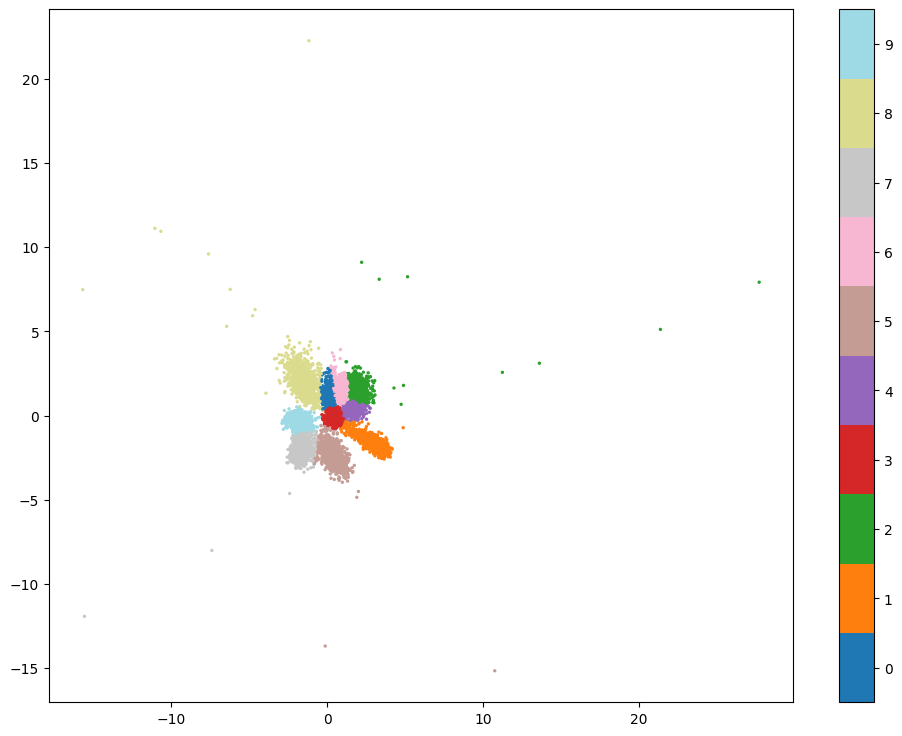

In [45]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=labels, s=2, cmap='tab20')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./invex_out/invex_embed/01_prediction_fm.pdf')

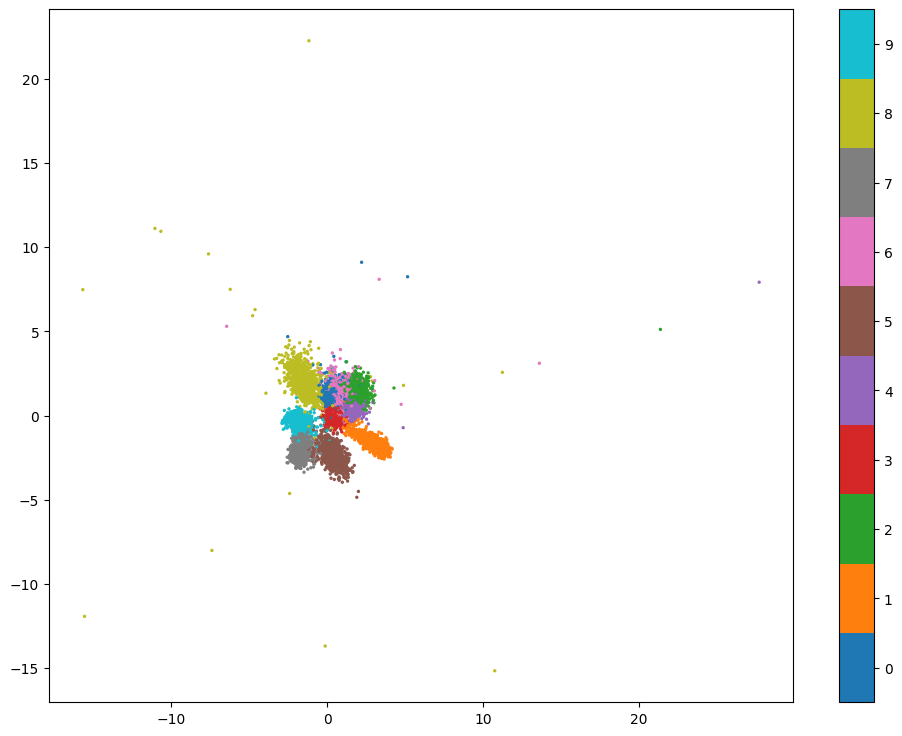

In [46]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./invex_out/invex_embed/02_ground_truth_fm.pdf')

In [47]:
# ! mkdir ./invex_out/invex_embed/

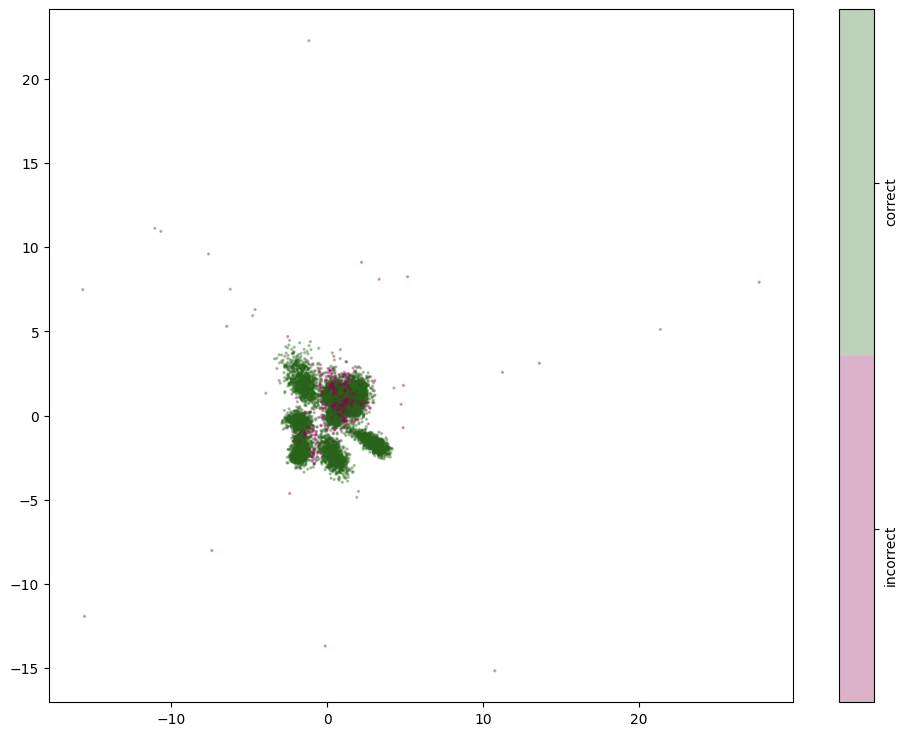

In [48]:
### Error Nodes
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=(labels==ilabels), s=2, cmap='PiYG', alpha=0.3)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['incorrect', 'correct', ])
cbar.ax.tick_params(rotation=90)

plt.savefig('./invex_out/invex_embed/03_errors_fm.pdf', bbox_inches='tight')

### plot on a 2D map, the decision boundary

In [49]:
ng = 1000
_a,_b,_c,_d = embeddings[:,0].min()-0.1, embeddings[:,0].max()+0.1, embeddings[:,1].min()-0.1, embeddings[:,1].max()+0.1
xg, yg = torch.linspace(_a, _b, ng), torch.linspace(_c, _d, ng)
xg, yg = torch.meshgrid(xg, yg)
xyg = torch.stack([xg.reshape(-1), yg.reshape(-1)], dim=-1)

/home/tsuman/ProgramFiles/miniconda3/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [50]:
BS = 1000
output = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier(xx, hard=True)
#         yout = classifier(xx)
        output.append(torch.argmax(yout, dim=1).cpu())
        
output = torch.cat(output, dim=0)

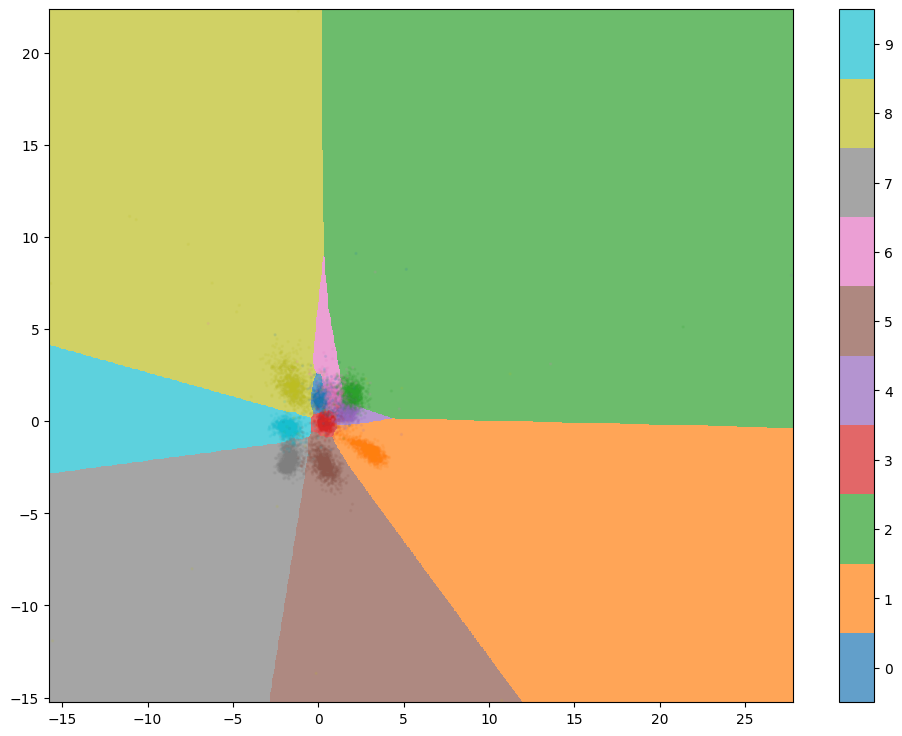

In [51]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10', alpha=0.1)

plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.7, cmap='tab10',
           aspect='auto', origin='lower')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

plt.savefig('./invex_out/invex_embed/04_DecisionBoundary_Class_fm.pdf', bbox_inches='tight')

In [52]:
## display different class boundary
BS = 1000
output2 = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier(xx, hard=True)
        output2.append(torch.argmax(classifier.cls_confidence, dim=1).cpu())
output2 = torch.cat(output2, dim=0)

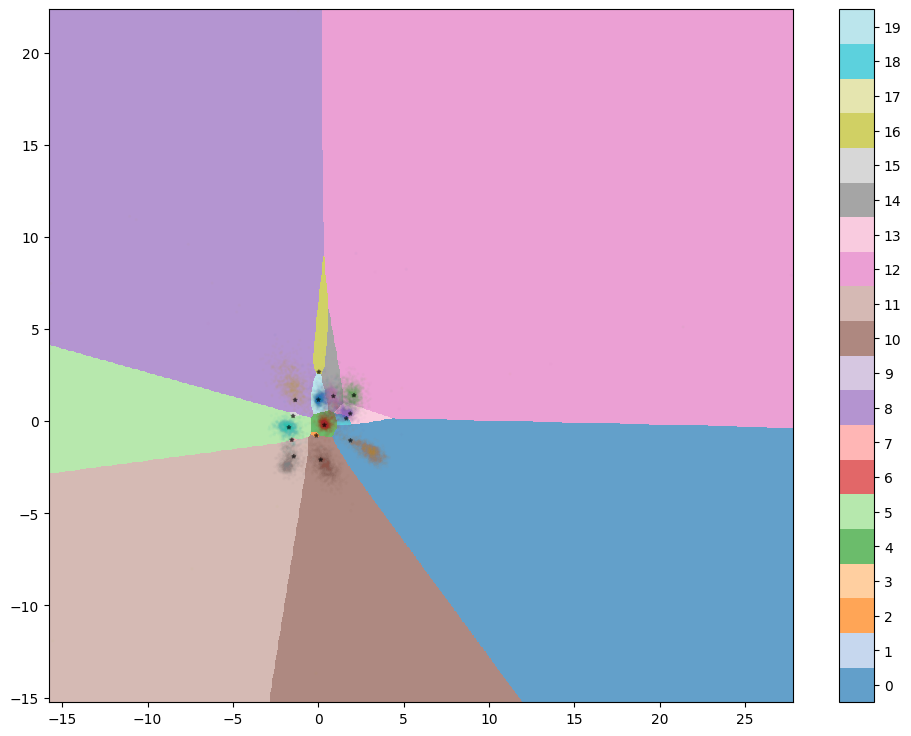

In [57]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10', alpha=0.02)

plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.7, cmap='tab20',
           aspect='auto', origin='lower')

cbar = plt.colorbar(ticks=range(20), #label='classes', 
                    boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(list(range(20)))

### plot centroids as well
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k', s=7)
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k', s=7)
alpha_count = ((set_count/set_count.max())>0).cpu()/2.
plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k', s=7, alpha=alpha_count)

plt.xlim(xg.min(), xg.max())
plt.ylim(yg.min(), yg.max()) 
plt.savefig('./invex_out/invex_embed/05_DecisionBoundary_Sets_fm.pdf', bbox_inches='tight')

### Hard train accuracy with count per classifier

In [54]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|████████████████████████████████████████████████| 1200/1200 [00:02<00:00, 516.59it/s]

Hard Train Acc:96.94%
[6007, 0, 6, 0, 6044, 5928, 0, 43, 5844, 0, 5989, 6034, 5693, 4743, 6366, 6, 24, 0, 1417, 5856]


In [55]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(15, device='cuda:0')

In [56]:
#### classifier with class representation
torch.argmax(classifier.cls_weight, dim=1)

tensor([1, 9, 5, 0, 3, 9, 0, 7, 8, 0, 5, 7, 2, 4, 6, 9, 6, 1, 4, 0],
       device='cuda:0')

### analyze per classifier accuracy

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(backbone(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
# set_acc/set_count

In [ ]:
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t {cnt},\t {cls}\t {acc*100:.2f}%")